# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится.

Постройте модель с максимально большим значением *accuracy*. Нужно довести долю правильных ответов по крайней мере до 0.75

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:  
сalls — количество звонков,  
minutes — суммарная длительность звонков в минутах,  
messages — количество sms-сообщений,  
mb_used — израсходованный интернет-трафик в Мб,  
is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


#### Часть 1. [Изучение файлов, получение общей информации.](#part1)

#### Часть 2. [Разбивка данных на выборки](#part2)

#### Часть 3. [Исследование моделей](#part3)
* [1. Решающее дерево.](#part3.1)
* [2. Случайный лес](#part3.2)
* [3. Логистическая регрессия](#part3.3)

#### Часть 4. [Проверка на тестовой выборке](#part4)

#### Часть 5. [Проверка на адекватность](#part5)

#### [Общий вывод](#part6)


<a id='part1'></a>
## 1. Изучение файла, получение общей информации.

In [1]:
# Импортируем библиотеки для работы
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('datasets/users_behavior.csv')
df.info()
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Согласно условиям, предобработка не требуется.  
Данные содержат 4 признака.   
Целевой признак принимает два значения, следовательно это задача классификации.

<a id='part2'></a>
## 2. Разбивка данных на выборки

Спрятанной тестовой выборки нет. Следовательно, разиваем данные в соотношении 3:1:1.

In [2]:
df_train_and_test, df_valid = train_test_split(df, test_size=0.2, random_state=12345)
df_train, df_test = train_test_split(df_train_and_test, test_size=0.25, random_state=12345)

print(df_train.shape)
print(df_test.shape)
print(df_valid.shape)

(1928, 5)
(643, 5)
(643, 5)


Данные разделены на тренировочную(60%), валидационную(20%) и тестовую выборки(20%).

<a id='part3'></a>
## 3. Исследование моделей

In [3]:
# Разделяем признаки и целевой признак

features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

<a id='part3.1'></a>
### 3.1 Решающее дерево

Проверим, как изменяется accuracy на двух выборках при изменении параметров max_depth и min_samples_leaf

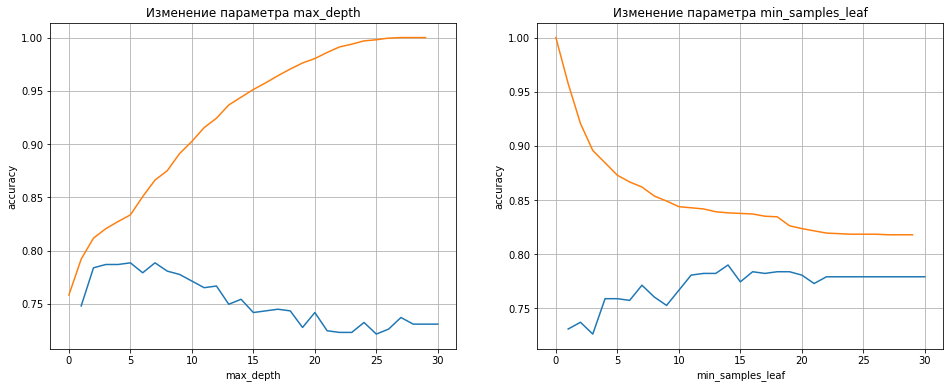

In [4]:
import matplotlib.pyplot as plt
j=0
fig, ax = plt.subplots(1,2,figsize=(16,6))
for param in ['max_depth','min_samples_leaf']:
    accuracy_list=[]
    
    for i in range(1,31):
        if param == 'max_depth':
            model = DecisionTreeClassifier(random_state=12345,max_depth=i)
        elif param == 'min_samples_leaf':
            model = DecisionTreeClassifier(random_state=12345,min_samples_leaf=i)
        
        model.fit(features_train, target_train)
    
        valid_predictions = model.predict(features_valid)
        train_predictions = model.predict(features_train)
        accuracy_train = accuracy_score(target_train, train_predictions)
        accuracy_valid = accuracy_score(target_valid, valid_predictions)
        accuracy_list.append([i, accuracy_valid, accuracy_train])
    DecisionTree_accuracy = pd.DataFrame(accuracy_list,
                                             columns=['param','accuracy_valid','accuracy_train'])
    x = DecisionTree_accuracy['param']
    y1 = DecisionTree_accuracy['accuracy_valid']
    y2 = DecisionTree_accuracy['accuracy_train']
    ax[j].plot(x,y1,y2)
    title = 'Изменение параметра ' + param
    ax[j].set_title(title)
    ax[j].set_xlabel(param)
    ax[j].set_ylabel('accuracy')
    ax[j].grid()
    ax[j].set_xticks([i for i in range(0,35,5)])
    j+=1

Как видно из графиков, после значения max_depth=8, точность модели на валидационной выборке начинает резко падать, модель начинает переобучаться. Следовательно, перебирать будем значения от 1 до 8.

При увеличении параметра min_samples_leaf точность на обучающей выборке падает, а на валидационной растет.  
Перебирать будем значения от 10 до 14.

В данных 4 признака, так что значения max_features будем перебирать от 1 до 4.

Найдем наиболее удачную модель с помощью GridSearchCV.

In [5]:
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier(random_state=12345)
depth =   [i for i in range(1,9)]
leafs =   [i for i in range(10,15)]
features = [i for i in range(1,5)]

dec_tree_params = {'max_depth': depth, 'min_samples_leaf': leafs, 
                   'max_features':features}
grid = GridSearchCV(model,dec_tree_params,scoring='accuracy',n_jobs=-1)
grid.fit(features_train,target_train)
print('Лучшие параметры модели DecisionTreeClassifier:')
display(grid.best_params_)
print('Accuracy на тестовой выборке: ',grid.best_score_)

Лучшие параметры модели DecisionTreeClassifier:


{'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 13}

Accuracy на тестовой выборке:  0.8106856873696252


In [6]:
model = DecisionTreeClassifier(random_state=12345, max_depth=grid.best_params_['max_depth'],
                               min_samples_leaf=grid.best_params_['min_samples_leaf'], 
                               max_features=grid.best_params_['max_features'])
model.fit(features_train, target_train)
valid_predictions = model.predict(features_valid)
print('Accuracy на валидационной выборке:')
print(accuracy_score(target_valid, valid_predictions))

Accuracy на валидационной выборке:
0.7931570762052877


### Вывод
Лучшие параметры решающего дерева:  
max_depth = 6  
max_features = 3    
min_samples_leaf = 13  

Accuracy на тестовой выборке:  0.8106856873696252  
Accuracy на валидационной выборке: 0.7947122861586314  

<a id='part3.2'></a>
### 3.2 Случайный лес

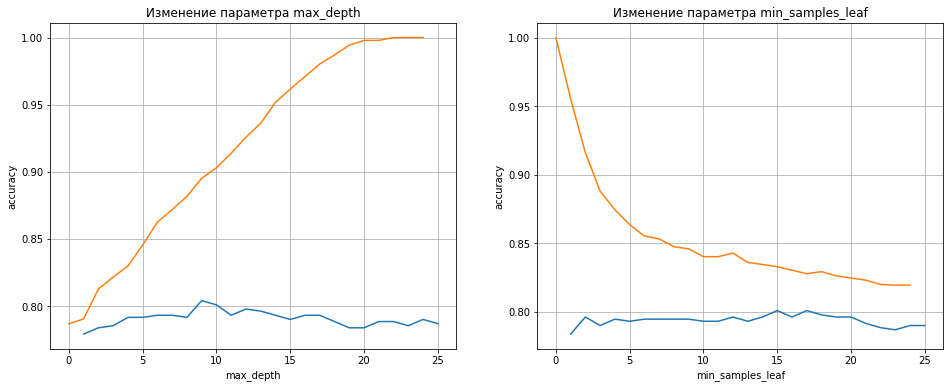

In [7]:
j=0
fig, ax = plt.subplots(1,2,figsize=(16,6))
for param in ['max_depth','min_samples_leaf']:
    accuracy_list=[]
    
    for i in range(1,26):
        if param == 'max_depth':
            model = RandomForestClassifier(random_state=12345,max_depth=i)
        elif param == 'min_samples_leaf':
            model = RandomForestClassifier(random_state=12345,min_samples_leaf=i)
                       
        model.fit(features_train, target_train)
    
        valid_predictions = model.predict(features_valid)
        train_predictions = model.predict(features_train)
        accuracy_train = accuracy_score(target_train, train_predictions)
        accuracy_valid = accuracy_score(target_valid, valid_predictions)
        
        accuracy_list.append([i, accuracy_valid, accuracy_train])
        
    DecisionTree_accuracy = pd.DataFrame(accuracy_list,
                                             columns=['param','accuracy_valid','accuracy_train'])
    x = DecisionTree_accuracy['param']
    y1 = DecisionTree_accuracy['accuracy_valid']
    y2 = DecisionTree_accuracy['accuracy_train']
    ax[j].plot(x,y1,y2)
    title = 'Изменение параметра ' + param
    ax[j].set_title(title)
    ax[j].set_xlabel(param)
    ax[j].set_ylabel('accuracy')
    ax[j].grid()
    ax[j].set_xticks([i for i in range(0,30,5)])
    j+=1

Как видно из графиков, точность валидационной выборки не сильно изменяется при изменении значения max_depth, тогда как точность обучающей выборки растет.  
Для перебора выберем значения от 6 до 14.

При увеличении параметра min_samples_leaf точность на обучающей выборке падает, а на валидационной практически не изменяется.  
Перебирать будем значения от 10 до 14.

n_estimators будем перебирать от 10 до 200 с шагом 10. 

В данных 4 признака, так что значения max_features будем перебирать от 1 до 4.

Найдем наиболее удачную модель с помощью GridSearchCV.

In [8]:
model = RandomForestClassifier(random_state=12345)

depth =   [9,10,14,16]
leafs =   [i for i in range(10,14)]
estim = [i for i in range(10,100,10)]
features = [i for i in range(1,5)]

ran_for_params = {'max_depth': depth, 'min_samples_leaf': leafs, 
                   'n_estimators':estim , 'max_features':features}
grid = GridSearchCV(model,ran_for_params,scoring='accuracy',n_jobs=1)
grid.fit(features_train,target_train)
print('Лучшие параметры модели RandomForestClassifier:')
display(grid.best_params_)
print('Accuracy на тестовой выборке: ',grid.best_score_)

Лучшие параметры модели RandomForestClassifier:


{'max_depth': 16,
 'max_features': 2,
 'min_samples_leaf': 10,
 'n_estimators': 80}

Accuracy на тестовой выборке:  0.8205410133907544


In [9]:
model = RandomForestClassifier(random_state=12345, max_depth=grid.best_params_['max_depth'],
                               min_samples_leaf=grid.best_params_['min_samples_leaf'], 
                               n_estimators = grid.best_params_['n_estimators'],
                               max_features=grid.best_params_['max_features'])
model.fit(features_train, target_train)
valid_predictions = model.predict(features_valid)
print('Accuracy на валидационной выборке:')
print(accuracy_score(target_valid, valid_predictions))

Accuracy на валидационной выборке:
0.7947122861586314


### Вывод
Лучшие параметры случайного леса:  
max_depth = 16  
max_features = 2      
min_samples_leaf = 10  
n_estimators = 80  

Accuracy на тестовой выборке:  0.8205410133907544  
Accuracy на валидационной выборке: 0.80248833592535  

<a id='part3.3'></a>
### 3.3 Логистическая регрессия

In [10]:
model = LogisticRegression(random_state=12345)
iters =   [i for i in range(100,1000,100)]
C = [0.0001,0.001,0.01,0,1,10,100]


log_reg_params = {'max_iter': iters, 'C': C}
                   

grid = GridSearchCV(model,log_reg_params,scoring='accuracy',n_jobs=-1)
grid.fit(features_train,target_train)
print('Лучшие параметры модели RandomForestClassifier:')
display(grid.best_params_)
print('Accuracy на тестовой выборке: ',grid.best_score_)

Лучшие параметры модели RandomForestClassifier:


{'C': 0.01, 'max_iter': 100}

Accuracy на тестовой выборке:  0.7339196554740596


In [11]:
model = LogisticRegression(random_state=12345, max_iter=grid.best_params_['max_iter'],
                               C=grid.best_params_['C'])
                               
model.fit(features_train, target_train)
valid_predictions = model.predict(features_valid)
print('Accuracy на валидационной выборке:')
print(accuracy_score(target_valid, valid_predictions))

Accuracy на валидационной выборке:
0.702954898911353


### Вывод

Исследовано три модели: дерево решений, случайный лес и логистическая регрессия.  
Для каждой из моделей методом GridSearchCV былы найдены лучшие значения гиперпараметров.  
Для дерева решений исследовались гиперпараметры max_depth, max_features, min_samples_leaf.  
Для случайного леса исследовались гиперпараметры max_depth, max_features, min_samples_leaf, n_estimators.  
Для логистической регрессии исследовались параметры iters, C.  

Самые высокие значения accuracy оказались у случайного леса с параметрами: 
* max_depth = 16  
* max_features = 2      
* min_samples_leaf = 10  
* n_estimators = 80  

<a id='part4'></a>
## 4. Проверка модели на тестовой выборке

In [12]:
model = RandomForestClassifier(random_state=135, max_depth=16, min_samples_leaf=10, 
                               n_estimators=80, max_features=2)
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
print('Accuracy на тестовой выборке:')
print(accuracy_score(target_test, test_predictions))

Accuracy на тестовой выборке:
0.7931570762052877


### Вывод
Точность выбранной модели на тренировочной, валидационной и тестовой выборках изменяется в пределах 2%.  

* Accuracy(тренировочная)   = 0.8205410133907544

* Accuracy(валидационная)   = 0.80248833592535

* Accuracy(тестовая)        = 0.7931570762052877


<a id='part5'></a>
## 5. Проверка модели на адекватность

In [13]:
from sklearn.dummy import DummyClassifier

strategies = ['most_frequent', 'stratified']

scores = []

for s in strategies:

    dummy = DummyClassifier(strategy = s, random_state = 12345)
    dummy.fit(features_train, target_train)
    accuracy = dummy.score(features_test, target_test)
    scores.append(accuracy)

print('Accuracy most_frequent:',scores[0])
print('Accuracy stratified:',scores[1])

Accuracy most_frequent: 0.6889580093312597
Accuracy stratified: 0.6003110419906688


### Вывод
Accuracy DummyClassifier на тренировочных данных заметно ниже, чем accuracy выбранной модели.

<a id='part6'></a>
## Общий вывод

В результате работы было проверено три модели: дерево решений, случайный лес и логистическая регрессия.  
Каждая модель была исследована и методом GridSearchCV были подобраны оптимальные значения гиперпараметров.  

В результате исследования оказалось, что наиболее удачной моделью стал случайный лес(RandomForestClassifier) со следующими параметрами:
* max_depth = 16
* max_features = 2
* min_samples_leaf = 10
* n_estimators = 80

Точность выбранной модели была проверена на тестовой выборке, а также проверена на адекватность путем сравнения с DummyClassifier.

Accuracy(тренировочная) = 0.8205410133907544  
Accuracy(валидационная) = 0.80248833592535  
Accuracy(тестовая) = 0.7931570762052877  

Accuracy Dummy most_frequent = 0.6889580093312597  
Accuracy Dummy stratified: = 0.6003110419906688